# Proyek Pertama : Potability Prediction Project
- **Nama:** Verzha Mahardika
- **Email:** verzhamahardhika@gmail.com
- **ID Dicoding:** verzha_mahardika

### Data Collection

##### Import Library

Import Library yang kita butuhkan dari proses Data Loading Hingga Evaluasi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.utils import resample, shuffle
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

##### Data Loading

Dataset dimuat dari file `water_potability.csv`. Ini adalah dataset yang berisi informasi terkait kualitas air dan apakah air tersebut layak minum (`Potability` = 1) atau tidak (`Potability` = 0).


In [2]:
df = pd.read_csv('dataset/water_potability.csv')
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


### Data Preprocessing

##### Menghapus Data Duplicate jika ada

Proses ini bertujuan untuk menghapus baris data yang duplikat agar tidak mempengaruhi analisis dan model. Duplikat dapat menyebabkan bias dalam pelatihan model.


In [3]:
df.drop_duplicates(inplace=True)

##### Check & Handle Missing Value

Pada dataset ini ditemukan beberapa nilai kosong (missing value).

In [4]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Terdapat missing value pada feature `ph` sebanyak 491 data, `Sulfate` sebanyak 781, dan `Trihalomethanes` 162.

##### Menghapus Missing Value dari setiap kolom

Semua baris yang mengandung nilai hilang dihapus dari dataset menggunakan metode **`dropna()`**, sehingga hanya data yang lengkap yang digunakan dalam pemodelan. Pendekatan ini dipilih untuk menjaga kesederhanaan dan menghindari asumsi terhadap distribusi data.

In [5]:
df = df.dropna()

# Memeriksa kembali apakah masih ada missing values
df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

Setelah melakukan penghapusan missing value, dapat terlihat tidak ada lagi missing value

##### Deteksi dan Menangani outlier

Sebelum melakukan penanganan outlier, data divisualisasikan menggunakan **boxplot**. Visualisasi ini membantu mengidentifikasi outlier secara visual.


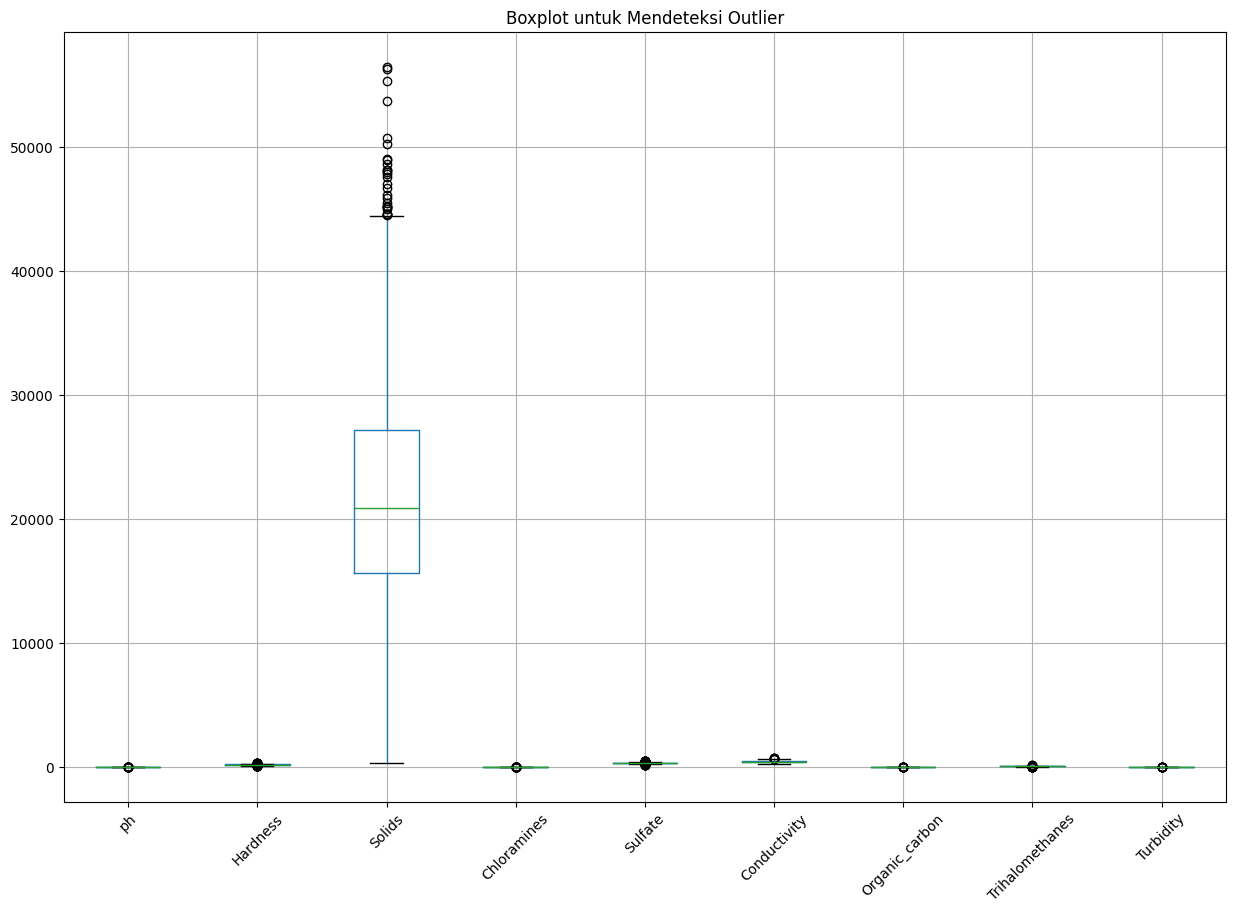

In [6]:
# Membuat boxplot untuk setiap fitur dalam dataset
plt.figure(figsize=(15, 10))
df.drop('Potability', axis=1).boxplot()
plt.title('Boxplot untuk Mendeteksi Outlier')
plt.xticks(rotation=45)
plt.show()

Dengan boxplot, kita bisa dengan cepat melihat fitur mana saja yang memiliki outlier dan seberapa ekstrem nilai-nilainya sebelum ditangani menggunakan metode IQR.


Penanganan outlier menggunakan metode IQR (Interquartile Range).


Setelah mengetahui fitur-fitur yang memiliki outlier melalui visualisasi boxplot, dilakukan penanganan menggunakan **metode IQR (Interquartile Range)**.

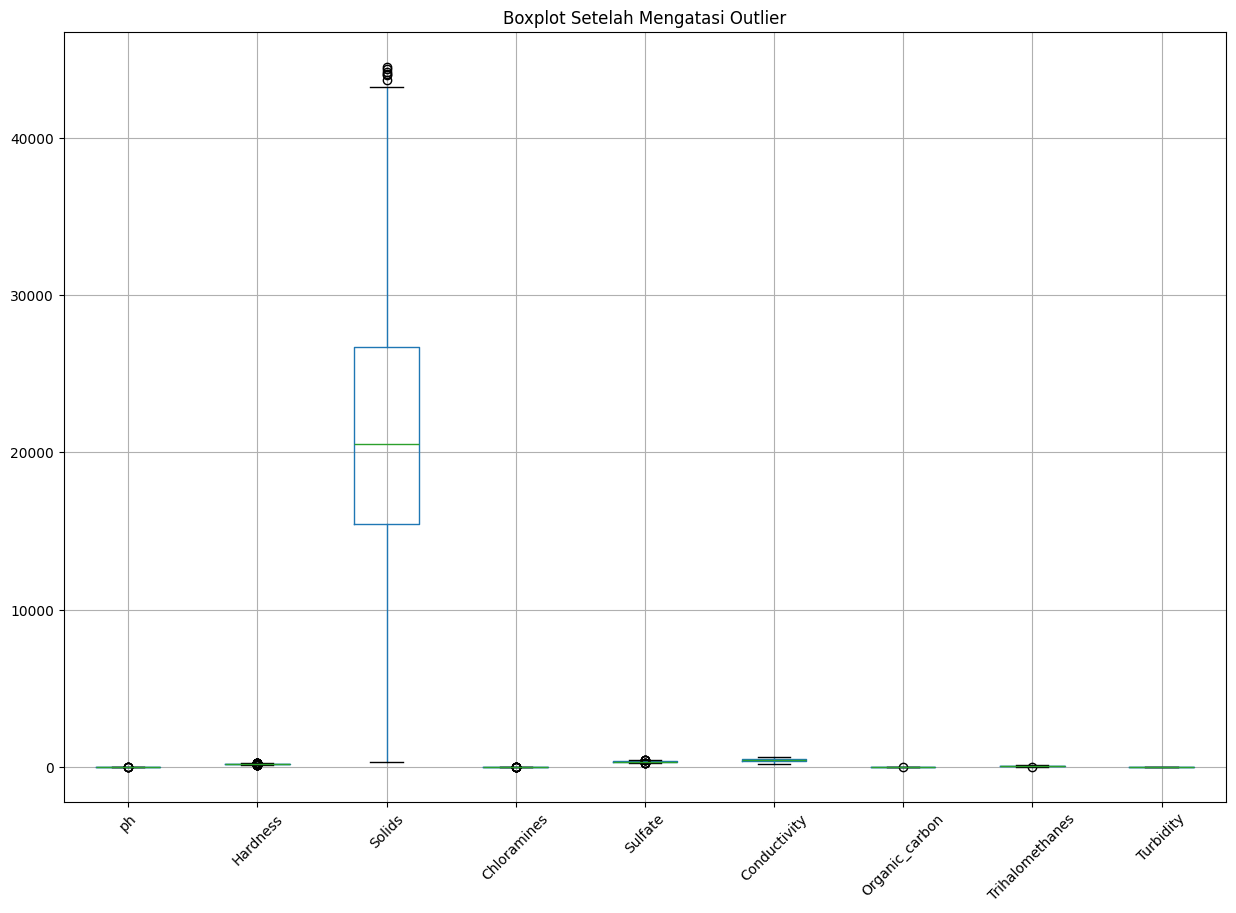

In [7]:
# Mengatasi outlier menggunakan metode IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Menentukan batas bawah dan atas
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Menghapus data yang berada di luar batas
df = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

# Menampilkan boxplot setelah mengatasi outlier
plt.figure(figsize=(15, 10))
df.drop('Potability', axis=1).boxplot()
plt.title('Boxplot Setelah Mengatasi Outlier')
plt.xticks(rotation=45)
plt.show()

Metode ini efektif untuk mengurangi pengaruh nilai ekstrem tanpa harus mengubah data. Setelah outlier dihapus, distribusi data menjadi lebih bersih dan model dapat dilatih dengan hasil yang lebih stabil.


### Exploratory Data Analysis (EDA)

##### Melihat Descriptive Statistic

Melihat **statistik deskriptif** dari dataset menggunakan fungsi `df.describe()`.


In [8]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000
mean,7.074828,196.318451,21477.156931,7.126371,333.632769,425.520946,14.416152,66.431721,3.972364,0.391862
std,1.438057,29.422687,8003.479699,1.423217,37.343075,79.940604,3.233243,15.496647,0.759442,0.488302
min,3.148712,117.791230,320.942611,3.205786,231.053687,201.619737,5.315287,24.532773,1.872573,0.000000
25%,6.115294,177.757844,15465.363183,6.185014,308.811000,365.976617,12.226733,56.222444,3.445210,0.000000
50%,7.026504,197.401340,20510.350601,7.135280,332.850686,421.318790,14.352930,66.206116,3.969602,0.000000
75%,7.996069,215.470602,26701.330507,8.066016,358.267328,481.833045,16.775306,77.294613,4.510548,1.000000
max,10.905076,275.746716,44499.728710,10.999995,436.294071,652.537592,23.373265,108.849568,6.083772,1.000000


##### Menampilkan Info tentang struktur dataframe

Melihat **struktur umum dari dataset**, termasuk jumlah data, tipe data, dan nilai null.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1794 entries, 3 to 3270
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               1794 non-null   float64
 1   Hardness         1794 non-null   float64
 2   Solids           1794 non-null   float64
 3   Chloramines      1794 non-null   float64
 4   Sulfate          1794 non-null   float64
 5   Conductivity     1794 non-null   float64
 6   Organic_carbon   1794 non-null   float64
 7   Trihalomethanes  1794 non-null   float64
 8   Turbidity        1794 non-null   float64
 9   Potability       1794 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 154.2 KB


- Dataset memiliki 1794 baris data & Terdapat 10 kolom.
- Semua kolom memiliki 1794 nilai non-null, artinya **tidak ada missing value**.

##### Cek imbalance data pada fitur target

Melihat **jumlah data pada masing-masing kelas label** dalam kolom `Potability`.

In [10]:
df.Potability.value_counts()

Potability
0    1091
1     703
Name: count, dtype: int64

Hasilnya:
- **0**: Sebanyak 1091 data (air tidak layak minum).
- **1**: Sebanyak 703 data (air layak minum).

Dari hasil ini terlihat bahwa data **tidak seimbang** (imbalanced), karena jumlah sampel dengan label 0 lebih banyak dibandingkan label 1. Ketidakseimbangan ini perlu diperhatikan saat membangun model, karena bisa memengaruhi performa prediksi, terutama pada kelas minoritas (air layak minum).

<Axes: ylabel='count'>

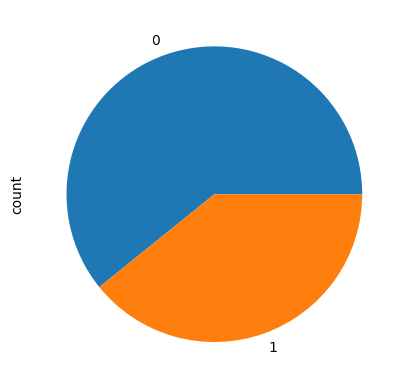

In [11]:
df.Potability.value_counts().plot(kind ='pie')

##### Mengatasi data imbalance

Ketidakseimbangan ini dapat menyebabkan model bias terhadap kelas mayoritas. Oleh karena itu, dilakukan penyeimbangan data dengan langkah-langkah berikut:

In [12]:
# Pisahkan data berdasarkan nilai Potability
non_drinkable = df.query("Potability == 0")  # kelas mayoritas
drinkable = df.query("Potability == 1")      # kelas minoritas

# Tentukan target jumlah data yang diinginkan (Hal ini mayoritas 1091)
target_count = 1091

# Perbanyak data minoritas dengan duplikasi secara acak
increased_minority = resample(
    drinkable,
    replace=True,
    n_samples=target_count,
    random_state=1
)

# Menggabungkan data yang seimbang
balanced_df = pd.concat([non_drinkable, increased_minority])

# Acak urutan baris agar tidak berurutan berdasarkan kelas
balanced_df = shuffle(balanced_df, random_state=1)

# Reset index agar rapi
balanced_df.reset_index(drop=True, inplace=True)

<Axes: ylabel='count'>

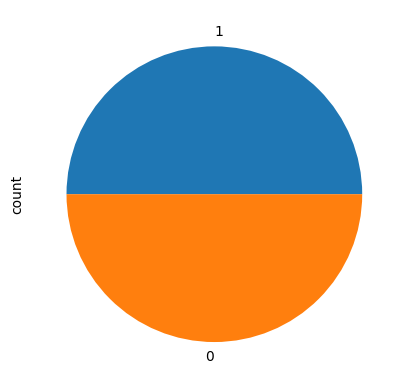

In [13]:
balanced_df.Potability.value_counts().plot(kind ='pie')

Dengan metode ini, model yang dibangun nantinya akan memiliki performa yang lebih adil dan tidak berat sebelah terhadap kelas tertentu.


##### Menampilkan Heatmap Correlation

Sebelum menampilkan Heatmap Correlation, mengcopy hasil balanced ke dalam variable df.

In [14]:
df = balanced_df.copy()

Melakukan Heatmap Correlation supaya mengetahui fitur yang memiliki korelasi tinggi terhadap fitur yanng lain.

Text(0.5, 1.0, 'Matrix Korelasi Fitur')

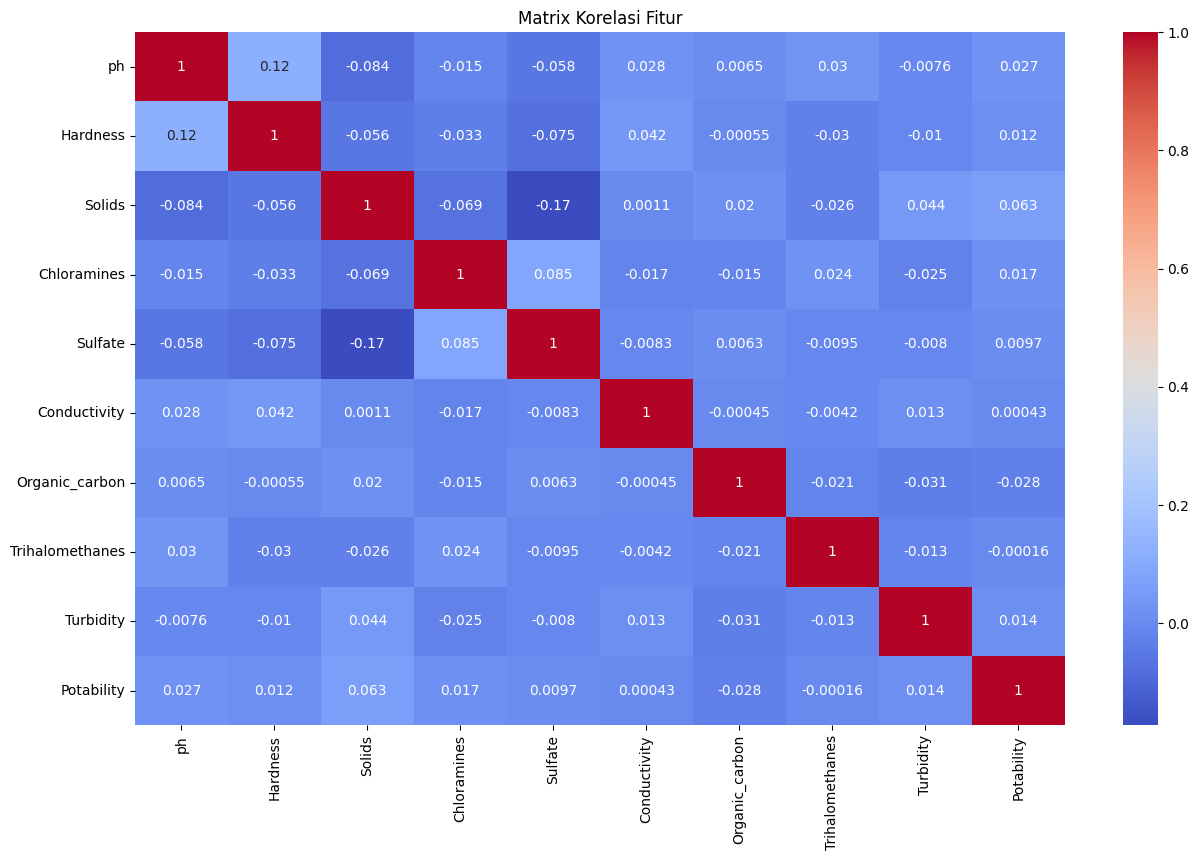

In [15]:
# Buat figure dengan ukuran berbeda
fig, ax = plt.subplots(figsize=(15, 9))

# Hitung korelasi dan tampilkan sebagai heatmap
correlation_matrix = df.corr()
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', ax=ax)

ax.set_title('Matrix Korelasi Fitur')

- Secara umum, korelasi antar fitur relatif rendah, yang menunjukkan tidak adanya multikolinearitas yang signifikan.
- Korelasi antara fitur dan target (`Potability`) juga rendah, yang berarti tidak ada fitur tunggal yang secara kuat menentukan kelayakan air minum. Oleh karena itu, model prediktif tetap diperlukan.
- Pasangan fitur seperti `Solids` dan `Sulfate` memiliki korelasi negatif sebesar **-0.17**, namun masih dalam batas yang dapat diterima.


##### Melihat Hubungan antara PH dan Hardness menggunakan scatter plot

Menampilkan dalam bentuk scatterplot hubungan antara **pH** (sumbu X) dan **Hardness** (sumbu Y) pada data kualitas air. Warna titik menunjukkan nilai **Potability**:


<Axes: xlabel='ph', ylabel='Hardness'>

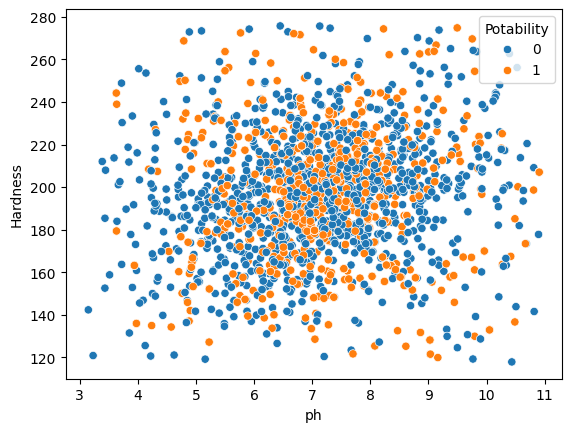

In [16]:
sns.scatterplot(x=df["ph"], y=df["Hardness"], hue=df.Potability,
data=df)

- Titik-titik biru dan oranye tersebar merata di seluruh grafik, yang menunjukkan bahwa tidak ada **pola yang jelas** antara pH dan Hardness dalam membedakan air layak dan tidak layak minum.
- Distribusi data terlihat cukup **acak dan padat** di rentang pH 6–8 dan hardness 150–220, baik untuk kelas 0 maupun 1.
- Hal ini menunjukkan bahwa **pH dan Hardness bukanlah indikator tunggal** yang cukup untuk menentukan kelayakan air minum.


##### Melihat Hubungan antara PH dan Hardness menggunakan scatter plot

<Axes: xlabel='ph', ylabel='Chloramines'>

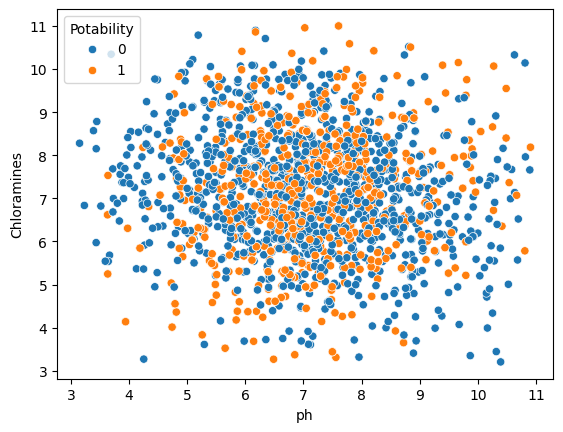

In [17]:
sns.scatterplot(x=df["ph"], y=df["Chloramines"], hue=df.Potability,
data=df)

- Nilai **pH** berkisar antara 3 hingga 11, sedangkan **Chloramines** berada di antara 3 hingga 11 juga, tetapi sebagian besar data terkonsentrasi pada rentang 6 hingga 8.
- Sama seperti scatter plot sebelumnya (pH vs Hardness), **tidak ada pola visual yang kuat** yang memisahkan kelas 0 dan 1 secara langsung.
- Namun, terdapat **sedikit kecenderungan** bahwa titik-titik oranye lebih banyak terkonsentrasi di daerah chloramines menengah (sekitar 6–8), meskipun masih bercampur.


##### Menampilkan Fitur yang paling kuat relasinya

In [18]:
df.corr().abs()['Potability'].sort_values(ascending = False)

Potability         1.000000
Solids             0.063039
Organic_carbon     0.027994
ph                 0.027031
Chloramines        0.017314
Turbidity          0.014497
Hardness           0.012188
Sulfate            0.009702
Conductivity       0.000430
Trihalomethanes    0.000164
Name: Potability, dtype: float64

**Insight:**
- Tidak ada fitur yang memiliki korelasi kuat terhadap Potability. Semuanya memiliki korelasi rendah (di bawah 0.1).
- Fitur dengan korelasi tertinggi terhadap Potability adalah Solids, namun hanya sebesar 0.063 → sangat lemah.
- Ini menunjukkan bahwa hubungan antara fitur-fitur ini dengan kelayakan air tidak linier secara signifikan.
- Oleh karena itu, model prediktif seperti Random Forest, XGBoost, atau SVM yang tidak hanya mengandalkan korelasi linier bisa lebih efektif digunakan.

### Data Preparation

##### Split Fitur(X) dan Label/target(y)

Memisahkan data fitur dari label agar bisa digunakan dalam pelatihan model

In [19]:
X = df.drop(['Potability'], axis = 1)
y = df['Potability']

##### Standarisasi Fitur

Melakukan standarisasi fitur menggunakan staandardscaler.

In [20]:
sc = StandardScaler()
features= X.columns
X[features] = sc.fit_transform(X[features])

##### Membagi Dataset menjadi data train dan data test

Membagi dataset menjadi data latih (training) dan data uji (testing). 20% dari data akan digunakan sebagai data uji (testing), dan sisanya (80%) sebagai data latih (training). 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

### Training Model & Optimization

##### Mencari Hyperparameter terbaik (tuning)

Melakukan tuning hyperparameter dari tiga model machine learning berbeda: Decision Tree, Random Forest, dan XGBoost, dengan menggunakan GridSearchCV atau RandomizedSearchCV.

In [22]:
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(random_state=42)
xgb =XGBClassifier(eval_metric = 'logloss', use_label_encoder=False)

#parameters for decision tree
para_dt = {
    'criterion':['gini','entropy'],
    'max_depth':np.arange(1, 50), 
    'min_samples_leaf':[1,2,4,5,10,20,30,40,80,100]
    }
grid_dt = GridSearchCV(
    dt, param_grid=para_dt, 
    cv=5
    ) #grid search

#parameters for random forest
params_rf = {
    'n_estimators':[50,100, 200],
    'max_depth':[None, 10, 20, 30], 
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf':[1, 2, 4],
    'max_features':['auto', 'sqrt']
    }

grid_rf = GridSearchCV(
    estimator = rf, 
    param_grid=params_rf, 
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
    )

#parameters untuk xgboost
params_xgb = {
    'n_estimators': [50,100,250,400,600,800,1000], 
    'learning_rate': [0.2,0.5,0.8,1]
    }
rs_xgb =  RandomizedSearchCV(
    xgb, param_distributions=params_xgb, 
    cv=5
    )

Mencari parameter terbaik untuk masing-masing model, sehingga nanti model yang dipilih bisa memiliki akurasi dan generalisasi terbaik saat digunakan pada data nyata.

##### Melatih Model dengan Hyperparameter tuning

melatih model dengan pencarian hyperparameter terbaik menggunakan data latih (X_train, y_train), lalu menampilkan hasil parameter terbaik dari masing-masing model.

In [23]:
grid_dt.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)
rs_xgb.fit(X_train, y_train)
print("Best parameters for Decision Tree:", grid_dt.best_params_)
print("Best parameters for Random Forest:", grid_rf.best_params_)
print("Best parameters for XGBoost:", rs_xgb.best_params_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\TUF GAMING\.conda\envs\verzha_new\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
188 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\TUF GAMING\.conda\envs\verzha_new\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\TUF GAMING\.conda\envs\verzha_new\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\TUF GAMING\.conda\envs\verzha_new\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validat

Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1}
Best parameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best parameters for XGBoost: {'n_estimators': 400, 'learning_rate': 0.8}


##### Membuat Model

Membuat ulang model ketiga model—Decision Tree, Random Forest, dan XGBoost—menggunakan parameter terbaik yang sudah ditemukan sebelumnya dari proses hyperparameter tuning.

In [24]:
dt = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=42, 
    min_samples_leaf=1, 
    random_state=42
    )
rf = RandomForestClassifier(
    n_estimators=100, 
    min_samples_leaf=2, 
    random_state=42
    )
xgb = XGBClassifier(
    n_estimators= 250, 
    learning_rate= 0.8
    )

##### Membuat dan melatih model ensemble dengan teknik Bagging

teknik ensemble yang melatih beberapa model (biasanya pohon keputusan) pada subset data yang diambil secara acak (dengan pengembalian), lalu menggabungkan prediksi mereka (misalnya dengan voting mayoritas untuk klasifikasi) untuk meningkatkan akurasi dan mengurangi overfitting.

In [25]:
bagging = BaggingClassifier(DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=46, 
    min_samples_leaf=2, 
    random_state=42),
    n_estimators = 100, 
    random_state = 42
    )

bagging.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                   max_depth=46,
                                                   min_samples_leaf=2,
                                                   random_state=42),
                  n_estimators=100, random_state=42)

### Evaluation

##### Menyimpan Model

In [26]:
classifiers = [('Decision Tree', dt), ('Random Forest', rf), ('XGBoost', xgb)]

##### Melatih Model

Melakukan pelatihan model dan memprediksi masing-masing model di dalam loop.



In [27]:
for classifier_name, classifier in classifiers:
 
    # Fit clf to the training set
    classifier.fit(X_train, y_train)    
   
    # Predict y_pred
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)

##### Evaluation Model

In [28]:
# Menampilkan Classification Report Algoritma Decision Tree
print("Classification Report Algoritma Decision Tree")
y_pred_dt= dt.predict(X_test)
print(classification_report(y_test, y_pred_dt))

Classification Report Algoritma Decision Tree
              precision    recall  f1-score   support

           0       0.88      0.67      0.76       233
           1       0.71      0.89      0.79       204

    accuracy                           0.78       437
   macro avg       0.79      0.78      0.78       437
weighted avg       0.80      0.78      0.77       437



- **Accuracy** - Persentase prediksi yang benar dari seluruh data. Hasilnya 0.78 (78%) model cukup akurat namun masih bisa ditingkatkan.

In [29]:
# Menampilkan Classification Report Algoritma Random Forest
print("Classification Report Algoritma Random Forest")
y_pred_rf= rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

Classification Report Algoritma Random Forest
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       233
           1       0.81      0.85      0.83       204

    accuracy                           0.84       437
   macro avg       0.84      0.84      0.84       437
weighted avg       0.84      0.84      0.84       437



- **Accuracy** - Persentase prediksi yang benar dari seluruh data. Hasilnya 0.84 (84%).

In [30]:
# Menampilkan Classification Report Algoritma XGBoost
print("Classification Report Algoritma XGBoost")
y_pred_xgb= xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

Classification Report Algoritma XGBoost
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       233
           1       0.75      0.88      0.81       204

    accuracy                           0.81       437
   macro avg       0.81      0.81      0.81       437
weighted avg       0.82      0.81      0.81       437



- **Accuracy** - Persentase prediksi yang benar dari seluruh data. Hasilnya 0.81 (81%).

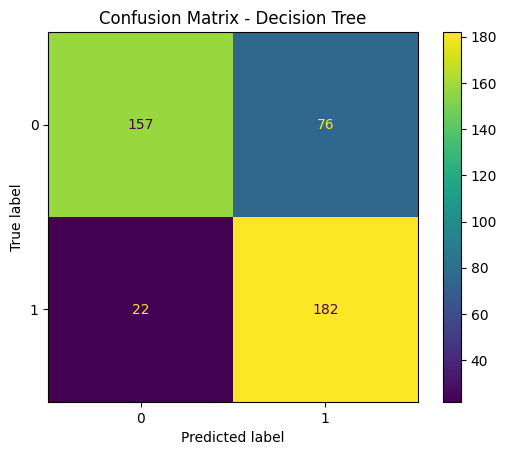

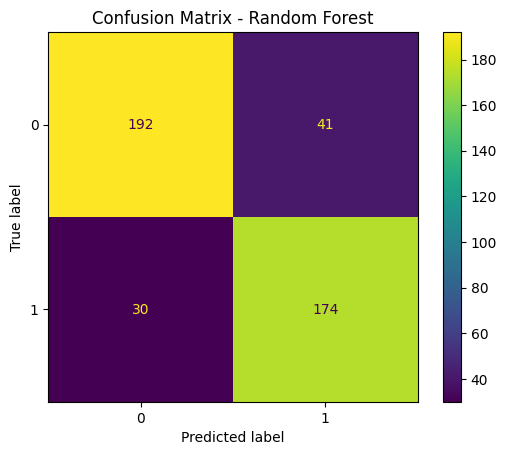

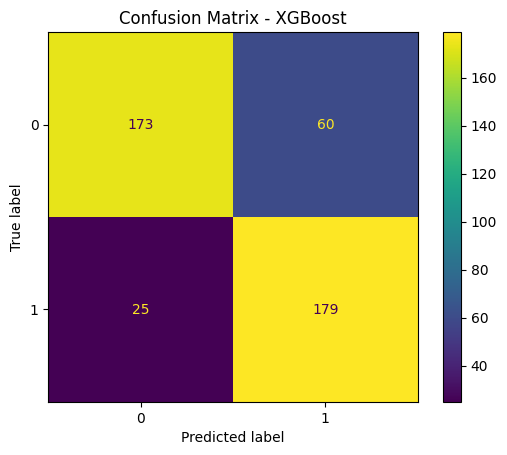

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

# List of classifiers and their predictions
classifiers_predictions = [
    ('Decision Tree', y_pred_dt),
    ('Random Forest', y_pred_rf),
    ('XGBoost', y_pred_xgb)
]

# Plot confusion matrices
for classifier_name, y_pred in classifiers_predictions:
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f'Confusion Matrix - {classifier_name}')
    plt.show()

✅ Decision Tree
- Model sangat bagus dalam mengenali data positif (recall tinggi).
- Tapi masih sering salah mengira data negatif sebagai positif (FP tinggi).
- Akurasi total: (TP + TN) / Total = (182 + 157) / 437 = 0.776 ≈ 77.6%

✅ Random Forest
- Model Random Forest memiliki akurasi, precision, dan recall yang lebih baik dibandingkan Decision Tree sebelumnya.
- False Positive dan False Negative-nya lebih rendah, menunjukkan model ini lebih seimbang dalam mengklasifikasi kedua kelas.
- Akurasi total:= (TP + TN) / Total = (174 + 192) / 437 ≈ 83.7%

✅ XGBoost
- XGBoost memiliki recall tertinggi (87.7%) di antara semua model — artinya sangat baik dalam menangkap kasus positif (1).
- Namun, precision-nya lebih rendah (74.9%), menunjukkan cukup banyak false positive.
- Cocok digunakan jika prioritas utama adalah menangkap sebanyak mungkin kasus positif (minim FN), misalnya dalam diagnosis awal atau sistem deteksi dini.


In [32]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# List of classifiers and their predictions
classifiers_predictions = [
    ('Decision Tree', y_pred_dt),
    ('Random Forest', y_pred_rf),
    ('XGBoost', y_pred_xgb)
]

# Evaluate each classifier
for classifier_name, y_pred in classifiers_predictions:
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Metrics for {classifier_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 30)

Metrics for Decision Tree:
Accuracy: 0.7757
Recall: 0.8922
Precision: 0.7054
F1 Score: 0.7879
------------------------------
Metrics for Random Forest:
Accuracy: 0.8375
Recall: 0.8529
Precision: 0.8093
F1 Score: 0.8305
------------------------------
Metrics for XGBoost:
Accuracy: 0.8055
Recall: 0.8775
Precision: 0.7490
F1 Score: 0.8081
------------------------------
